In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import vstack, load_npz

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report

%matplotlib inline

In [2]:
labels = np.load('data/labels.npy')

In [3]:
features = load_npz('data/features.npz')

In [4]:
labels

array([ True,  True,  True, ..., False, False, False])

In [5]:
features

<171236x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 18138124 stored elements in Compressed Sparse Row format>

In [6]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

In [7]:
clf = SGDClassifier()

In [8]:
# fit model to training data
clf.fit(X_train, y_train)

SGDClassifier()

In [9]:
# make predictions
predictions = clf.predict(X_test)
predictions

array([False, False, False, ..., False, False, False])

In [10]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.68      0.73      0.71     22945
        True       0.36      0.31      0.33     11303

    accuracy                           0.59     34248
   macro avg       0.52      0.52      0.52     34248
weighted avg       0.58      0.59      0.58     34248



In [11]:
sum(labels) / len(labels)

0.33060220981569294

In [13]:
%%time

scores = np.zeros((3, 6))
penalty = ['l2', 'l1', 'elasticnet']
alpha = [1e-4, 1e-3, 1e-2, 1e-1, 1]

for i, p in enumerate(penalty):
    for j, a in enumerate(alpha):
        clf = SGDClassifier(alpha=a, penalty=p)
        scores[i, j] = cross_val_score(clf, X_train, y_train, cv=3).mean()

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Conside

CPU times: user 21min 15s, sys: 12.4 s, total: 21min 28s
Wall time: 21min 15s


<AxesSubplot:>

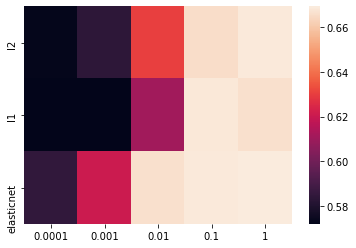

In [15]:
sns.heatmap(scores[:, :-1], xticklabels=alpha, yticklabels=penalty)

In [19]:
scores.argmax()

16

In [20]:
scores.max()

0.6692557013006327

In [21]:
# Create model with best performing hyperparameters
clf = SGDClassifier(alpha=1, penalty='elasticnet')

# Fit on all of your (training) data
clf.fit(X_train, y_train)

SGDClassifier(alpha=1, penalty='elasticnet')

In [22]:
# Evaluate on Holdout set
print(clf.score(X_test, y_test))

0.6699661294090166


In [7]:
import ray, logging
from ray import tune

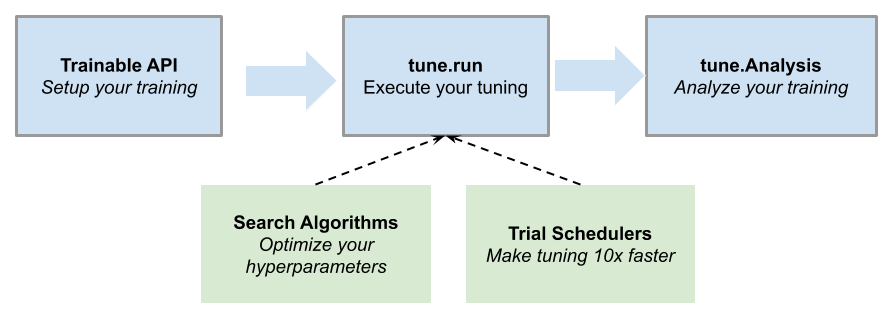

In [8]:
ray.init(logging_level=logging.ERROR, dashboard_host='0.0.0.0', dashboard_port=8265)

{'node_ip_address': '172.17.0.2',
 'raylet_ip_address': '172.17.0.2',
 'redis_address': '172.17.0.2:6379',
 'object_store_address': '/tmp/ray/session_2021-02-22_02-43-31_299511_589/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-02-22_02-43-31_299511_589/sockets/raylet',
 'webui_url': '172.17.0.2:8265',
 'session_dir': '/tmp/ray/session_2021-02-22_02-43-31_299511_589',
 'metrics_export_port': 60713,
 'node_id': 'fe8b64ac41fc185d4ecea3b84c87caf7ea0c0bea8e6ca46fbbd1d38b'}

In [10]:
def train_evaluate(parameterization):
    clf = SGDClassifier(alpha=parameterization['alpha'], penalty=parameterization['penalty'])
    
    tune.report(mean_accuracy=cross_val_score(clf, X_train, y_train, cv=3).mean())

In [ ]:
%%time
search_space = {
    "alpha": tune.loguniform(1e-4, 1),
    "penalty": tune.choice(['l1', 'l2', 'elasticnet'])
}

analysis = tune.run(train_evaluate, config=search_space, num_samples=15, verbose=1)

(pid=300) /opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
(pid=300)   warnings.warn("Maximum number of iteration reached before "


In [20]:
analysis.dataframe()

,mean_accuracy,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,experiment_id,date,timestamp,time_total_s,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,trial_id,config/alpha,config/penalty,logdir
0,0.580547,15.746661,False,NaN,NaN,1,692f71fb1426424ea83cf8eb6242b302,2021-02-22_02-04-59,1613959499,15.746661,755,fb98db0a3d5f,172.17.0.2,15.746661,0,1,5290d_00000,0.000123,elasticnet,/home/jovyan/ray_results/train_evaluate_2021-0...
1,0.655466,259.899904,False,NaN,NaN,1,becb10c4a927488cba653c30a29bc297,2021-02-22_02-09-06,1613959746,259.899904,754,fb98db0a3d5f,172.17.0.2,259.899904,0,1,5290d_00001,0.017248,l1,/home/jovyan/ray_results/train_evaluate_2021-0...
2,0.669402,5.470283,False,NaN,NaN,1,cfb02888dcdc49e397162f01d9fb3521,2021-02-22_02-04-54,1613959494,5.470283,756,fb98db0a3d5f,172.17.0.2,5.470283,0,1,5290d_00002,0.284523,elasticnet,/home/jovyan/ray_results/train_evaluate_2021-0...
3,0.582372,17.348665,False,NaN,NaN,1,9e6344ba36284078ad9f2656900d52ea,2021-02-22_02-05-09,1613959509,17.348665,757,fb98db0a3d5f,172.17.0.2,17.348665,0,1,5290d_00003,0.000115,elasticnet,/home/jovyan/ray_results/train_evaluate_2021-0...
4,0.668781,8.461670,False,NaN,NaN,1,4241294657d04616b5c1741d7ee338e0,2021-02-22_02-05-07,1613959507,8.461670,840,fb98db0a3d5f,172.17.0.2,8.461670,0,1,5290d_00004,0.083278,elasticnet,/home/jovyan/ray_results/train_evaluate_2021-0...
5,0.646407,6.126055,False,NaN,NaN,1,557e00f434574a88acdf1ab2a7338bb8,2021-02-22_02-05-10,1613959510,6.126055,859,fb98db0a3d5f,172.17.0.2,6.126055,0,1,5290d_00005,0.022361,l2,/home/jovyan/ray_results/train_evaluate_2021-0...
6,0.667256,9.709259,False,NaN,NaN,1,089b59aff54d4b558161b66bd6952e74,2021-02-22_02-05-21,1613959521,9.709259,878,fb98db0a3d5f,172.17.0.2,9.709259,0,1,5290d_00006,0.051596,elasticnet,/home/jovyan/ray_results/train_evaluate_2021-0...
7,0.664554,109.485059,False,NaN,NaN,1,7da3e95445a74b78ae61522a6018c0b5,2021-02-22_02-07-04,1613959624,109.485059,897,fb98db0a3d5f,172.17.0.2,109.485059,0,1,5290d_00007,0.237818,l1,/home/jovyan/ray_results/train_evaluate_2021-0...
8,0.601556,5.774481,False,NaN,NaN,1,ed5d4830ebc34c9c9d4e59caaf893191,2021-02-22_02-05-23,1613959523,5.774481,915,fb98db0a3d5f,172.17.0.2,5.774481,0,1,5290d_00008,0.002039,l2,/home/jovyan/ray_results/train_evaluate_2021-0...
9,0.607820,4.930144,False,NaN,NaN,1,21dcc8ed415946b692bd72ec78f65cca,2021-02-22_02-05-31,1613959531,4.930144,935,fb98db0a3d5f,172.17.0.2,4.930144,0,1,5290d_00009,0.003462,l2,/home/jovyan/ray_results/train_evaluate_2021-0...


In [25]:
def train_evaluate(parameterization):
    clf = SGDClassifier(alpha=parameterization['alpha'], penalty=parameterization['penalty'])
    X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, test_size=0.2)
    
    for i in range(1000):
        clf.partial_fit(X_t, y_t, classes=[False, True])
        
        if i % 100 == 0:
            tune.report(mean_accuracy=clf.score(X_val, y_val))

In [21]:
from ray.tune.schedulers import ASHAScheduler

In [26]:
%%time
search_space = {
    "alpha": tune.loguniform(1e-6, 1000),
    "penalty": tune.choice(['l1', 'l2', 'elasticnet'])
}

analysis = tune.run(
    train_evaluate, 
    config=search_space, 
    num_samples=50, 
    verbose=1,
    scheduler=ASHAScheduler(metric="mean_accuracy", mode="max"),
)

CPU times: user 56.7 s, sys: 1min 44s, total: 2min 40s
Wall time: 21min 51s


In [27]:
analysis.get_best_config(metric="mean_accuracy", mode="max")

{'alpha': 7.130813172664773, 'penalty': 'l2'}

In [28]:
# Create model with best performing hyperparameters
clf = SGDClassifier(alpha=7.131, penalty='l2')

# Fit on all of your (training) data
clf.fit(X_train, y_train)

SGDClassifier(alpha=7.131)

In [29]:
clf.score(X_test, y_test)

0.670929689324924

In [7]:
import pickle

In [31]:
with open('data/model.pickle', "wb") as f:
    pickle.dump(clf, f)

In [32]:
!ls data/

features.npz  labels.npy  Posts.xml  sgd.pickle


In [8]:
from scipy.sparse import csr_matrix

class SGDModel:
    def __init__(self):
        with open('data/model.pickle', 'rb') as f:
            self.model = pickle.load(f)
            
    async def __call__(self, starlette_request):
        v = await starlette_request.json()
        
        # convert from JSON payload to CSR_matrix
        features = csr_matrix((v['values'], (np.zeros(len(v['indices']), dtype='int32'), v['indices'])), shape=(1, 20000))
        
        return { "prediction": self.model.predict(features) }

In [9]:
from ray import serve

In [10]:
client = serve.start()

2021-02-22 04:01:50,065	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8265
2021-02-22 04:01:50,072	WARNING services.py:1619 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=Xgb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 2gb.
(pid=18249) 2021-02-22 04:01:52,699	INFO http_state.py:67 -- Starting HTTP proxy with name 'kZSjiv:SERVE_CONTROLLER_ACTOR:SERVE_PROXY_ACTOR-node:172.17.0.2-0' on node 'node:172.17.0.2-0' listening on '127.0.0.1:8000'


In [11]:
client.create_backend('sgd:v2', SGDModel)

(pid=18247) INFO:     Started server process [18247]


In [12]:
client.create_endpoint('se_classifier', backend="sgd:v2", route="/predict_csr")

(pid=18249) 2021-02-22 04:01:55,773	INFO controller.py:178 -- Registering route '/predict_csr' to endpoint 'se_classifier' with methods '['GET']'.


In [13]:
import requests

In [14]:
test_data = X_test[0]

In [15]:
test_data.data

array([1.15532502, 5.89009922, 0.52865771, 4.9971976 , 2.61911601,
       0.21815439, 1.12572524, 2.00337771, 1.54445005, 0.16168794,
       4.34143175, 0.1754359 , 4.26321106, 0.58481782, 0.17572965,
       2.64424677, 2.31275579, 0.79275807, 4.10757277, 1.64077112,
       0.44524699, 1.30722235, 1.92659312, 3.59187143, 1.46448454,
       3.14731124, 2.31237055, 0.1805399 , 2.1489765 , 3.51956811,
       4.88984169, 0.11026072, 2.54805838, 2.35461075, 4.15805899,
       4.35939699, 6.55914885])

In [17]:
response = requests.get("http://localhost:8000/predict_csr", json={
    'indices': X_test[0].indices.tolist(),
    'values': X_test[0].data.tolist()
})

In [18]:
response

<Response [200]>

In [19]:
response.text

'{\n  "prediction": [\n    false\n  ]\n}'

In [20]:
y_test[0]

False